In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
#download this file from https://gdb.unibe.ch/downloads/
smifile = "ChEMBL.FL.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","No","Int"])
data

,smiles,No,Int
0,CC(=O)C1=CC2=C(OC(C)(C)C=C2)C=C1O,CHEMBL443462,NaN
1,OC(CCC1=CC=CC=C1)C=CC=CC1=CC=CC=C1,CHEMBL500790,NaN
2,CCCCCOC1=CC=C(OC2=CC=C(O)C=C2)C=C1,CHEMBL500079,NaN
3,CC1=C2C=CC=CC2=C(C=C1)C(CC=C)OC(=O)C=C,CHEMBL503411,NaN
4,CC1=CCCC(C)=CC2OC(=O)C(=C)[C-]2C(O)C1,CHEMBL503702,NaN
...,...,...,...
10364,CSC1=CC=C(C=C2C=CC3=CC=CC=C23)C=C1,CHEMBL2358272,NaN
10365,CC1=CC=C(C=C2C=C(OC2=O)C2=CC=CC=C2)C=C1,CHEMBL2356702,NaN
10366,O=C1OC(=CC=C1)C1=C2C=CC=CC2=CC=C1,CHEMBL2357034,NaN
10367,CC1=CCCC2(C)OC2C2OC(=O)C(=C)C2CC1,CHEMBL2357484,NaN


In [3]:
#double-check to see if any empty record exists
for i,s in enumerate(data["smiles"]):
    if len(s) == 0:
        print(i,len(s))

In [4]:

#divide small molecules into training and test sets. 
#there are a total of around 10,000 small molecules. training set has around 8,000, test set, around 2,000
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(7776,)
(2593,)


In [5]:

#we add characters '!' and 'E', as symbols for starting and ending the small molecules SMILES code
charset=set("".join(list(data.smiles))+"!E")
#we generate two dictionaries that map a character to an integer and vice versa
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))

#to feed molecule representations to the RNN, first we have to make sure they are all of equal lenghts
#embed is the length of the vector representing a molecule
embed=max([len(smile) for smile in data.smiles]) + 5
print("set of SMILES characters:")
print(str(charset))
print('total characters, length of each molecule:',len(charset), embed)

set of SMILES characters:
{'4', '(', '+', 'M', 'C', '#', '2', '6', '!', '1', 'S', 'E', '3', ')', ']', '5', '[', 'H', '-', 'g', '=', 'O'}
total characters, length of each molecule: 22 53


O=C1C(CC2=CC=CC=C2)=COC2=CC=CC=C12


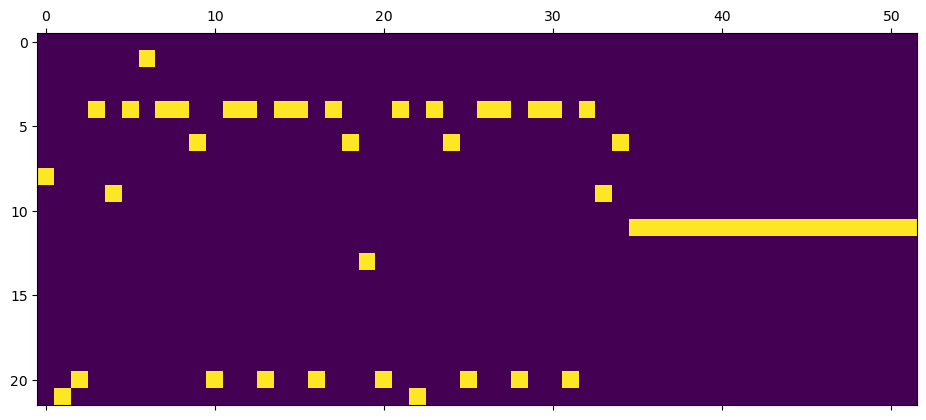

In [10]:

#define a function that takes a list of SMILES codes, and return a three-dimensional array as their numerical representation
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

#convert test and train sets to vector format.
#notice how the y representation is lagged by one position from the x representation.
#this is needed for prediction purposes in RNN, where characters of a SMILES representation try to predicted the next character
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
#visual representation of the vector corresponding to the first small molecule
plt.matshow(X_train[0].T)
#print(X_train.shape)

In [16]:
#converting vector form back to SMILES representation for the first molecule:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!O=C1C(CC2=CC=CC=C2)=COC2=CC=CC=C12EEEEEEEEEEEEEEEEE'

In [17]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64
input_shape
output_dim

22

In [18]:
#defining an LSTM RNN
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [19]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 52, 22)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         22272       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [ ]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

In [ ]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [ ]:
model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

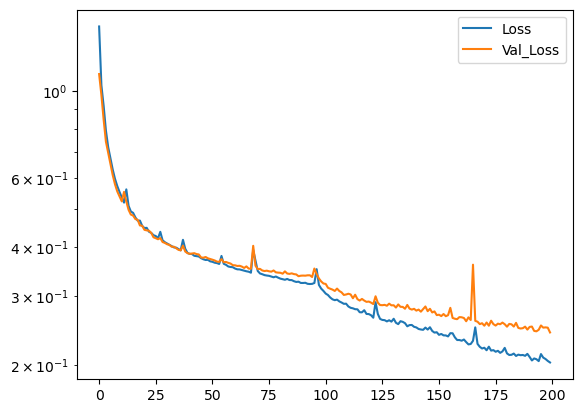

In [24]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [ ]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [ ]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [28]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [29]:
sample_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 22)]              0         
                                                                 
 lstm_2 (LSTM)               (1, 1, 64)                22272     
                                                                 
 dense_4 (Dense)             (1, 1, 22)                1430      
                                                                 
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


In [30]:
x_latent = smiles_to_latent_model.predict(X_test)

82/82 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 10ms/step
[   5  355 1543 1103  838   22 2420 2403  340  836]
9225     CC1C(=O)C(C)=C2C3=C4C(=C(C)C=CC4=CC=C3C)C12O
2452      CC1COC2=C1C(=O)C(=O)C1=CC=C3C(C)=CC=CC3=C21
8624       CC1(OC(=O)C2=CC=CC=C12)C1=C2C=CC=CC2=CC=C1
1833    CC1=CC=C(C=C1)C1=CC(=O)C2=C(C)C(C)=C(C)C=C2O1
7873      CC1=C(C(=O)C2=CC=C([O-])C=C2O1)C1=CC=CC=C1C
1413      CC1=C(O)C(=O)C=C2C1=CC=C1C(C)(C)C(=O)CCC21C
6130     CC(=O)C1=CC=C(S1)C1=CC=CC(=C1)C1=CC=CC(O)=C1
4518      CC(C)C1=C(O)C=C2C(C=CC3=C(C)C(C)=CC=C23)=C1
Name: smiles, dtype: object


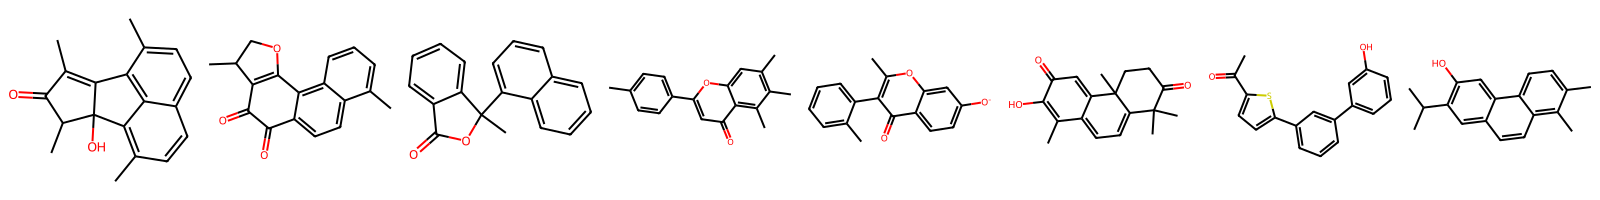

In [31]:
#most similar predictions to the molecule
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

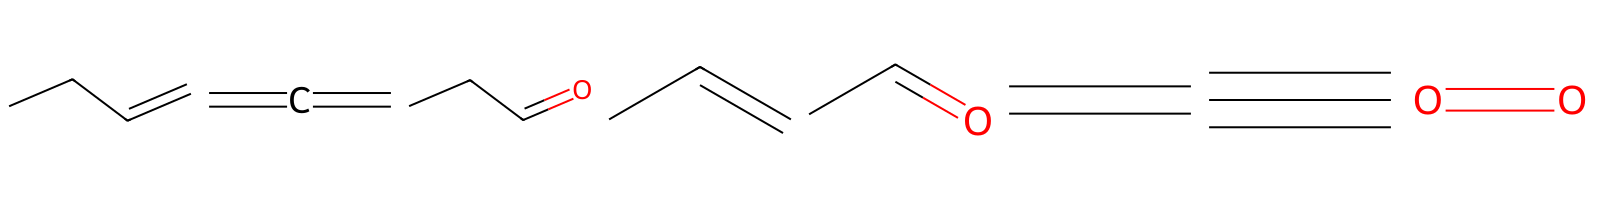

In [32]:
#most dissimilar predictions to the molecule
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

In [33]:
#computing LogP or octanol-water partition coefficient
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.6459003  0.24136783] 0.8872681


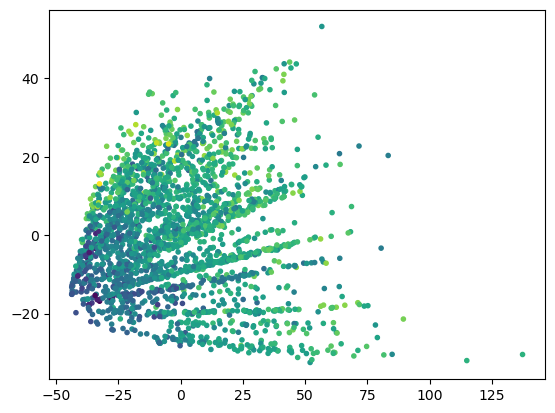

In [34]:
#observing that LogP of generated molecules slightly correlates with clusters of molecules using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))